## Projet Spark : Analyse de données d'un service de streaming musical


#### Context du projet  :
On considère un dataset d'un service de streaming musical à explorer.

L'objectif est de tirer des informations utiles sur l'utilisation de la plateforme, le comportement des utilisateurs et les tendances d'écoute, en utilisant les concepts fondamentaux de Spark, pour manipuler et analyser des données à grande échelle.

#### Dataset :
Le dataset utilisé, "spotify_logs.json", contient des logs / journaux d'événements d'une application de streaming musical. Chaque entrée du dataset correspond à une interaction de l'utilisateur avec le service de streaming. Les attributs incluent des informations sur l'utilisateur, telles que son ID, son genre, le niveau d'abonnement, ainsi que des détails sur les événements comme la chanson écoutée, la page visitée, l'heure de l'événement, etc.

#### Objectif du Projet :
Le projet consiste à réaliser une série d'analyses et de calculs sur ces données en utilisant Apache Spark 


Ressource utile:
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/index.html

## Travail demandé et Livrables :
 
- Ecrire le code Pyspark qui permet de répondre aux questions ci dessous. 
- Rendre votre notebook avec la trace d'exécution de vos cellules.



In [3]:
#Import des libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when,countDistinct, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##  **Charger les données**

- Importer toutes autres libraries dont vous pourriez avoir besoin
- Instancier une session Spark
- Lire le dataset "spotify_logs.json"
- afficher le schéma des données


In [4]:
spark = SparkSession.builder.appName("music_stream_pyspark").getOrCreate()

In [5]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=music_stream_pyspark>

In [6]:
#votre code ici
df = spark.read.json("spotify_logs.json")
# df.show()
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## **Questions: Exploration et Analyse de données**

2. Combien de logs sont présents dans le dataset ?
3. Combien d'artistes sont présents dans le dataset?
4. Trouver le nombre d'utilisateurs inscrits dans le dataset ?
5. Quels sont les types de niveau d'abonnement (level) disponibles dans le dataset ?
6. Quelles sont les pages disponibles dans le dataset et combien de fois chacune d'elles a-t-elle été visitée ? 

7. Combien de logs a enregistré l'utilisateur d'id: 1138,

   Afficher les 5 premiers et les 5 derniers logs de cet utilisateur, que remarquez vous?
8. Combien de pages l'utilisateur avec l'id "" (empty string) n'a-t-il PAS visitée, afficher les .
9. De quel type d'utilisateurs s'agit il à votre avis?
10. Combien d'utilisateurs de chaque genre sont présents dans le dataset ?
11. Visualiser la répartition, Y a-t-il une différence significative entre le nombre d'utilisateurs de chaque genre ?
12. Quel est l'artiste le plus écouté dans le dataset et combien de fois ses chansons ont-elles été jouées ?
13. Combien de chansons différentes ont été jouées dans l'ensemble des logs ?

14. Visualiser le nombre de chansons jouées par heure,  À quelle heure de la journée les utilisateurs écoutent-ils le plus de chansons ?
15. Trouver les utilisateurs qui ont fait des upgrade et downgrade de leur abonnement?

16. Créer une vue temporaire répondre avec des requêtes SQL aux questions suivantes:

 a- Afficher les 3 premiers logs de l'utilisateur d'id 1046
 
 b- Trouver les pages que les utilisateurs ayant empty userID ont visité
 
 c- Combien de chansons ont été jouées par l'artiste le plus joué 
17. Proposer un axe d'analyse de votre choix ?


### 1 How many logs are present in the datase ?

In [8]:
df.count()

10000

### 2. How many artists are present in the dataset?

In [9]:
df.select("artist").show()
df.select("artist").count()

+--------------------+
|              artist|
+--------------------+
|       Showaddywaddy|
|          Lily Allen|
|Cobra Starship Fe...|
|          Alex Smoke|
|                NULL|
|                NULL|
|              Redman|
|     Ulrich Schnauss|
|                NULL|
|                NULL|
|               Jay-Z|
|         Evanescence|
|     Scissor Sisters|
|        3 Doors Down|
|       George Younce|
|              Aly-Us|
|                NULL|
|            BjÃÂ¶rk|
|      David Bromberg|
|          Nickelback|
+--------------------+
only showing top 20 rows



10000

### 3. How many distinct artists are present in the dataset?

In [14]:
df.select(countDistinct("artist")).show()
df.select(countDistinct("artist")).collect()[0][0]

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                  3617|
+----------------------+



3617

### 4. How many users are registered in the dataset?

In [10]:
df.groupby("gender").count().show()
df.select("firstName").count()

+------+-----+
|gender|count|
+------+-----+
|     F| 3820|
|  NULL|  336|
|     M| 5844|
+------+-----+



10000

### 5. What types of subscription levels are available in the dataset?

In [11]:
df.groupby("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free| 3076|
| paid| 6924|
+-----+-----+



### 6. What pages are available in the dataset, and how many times have each been visited? 

In [12]:
page_visits = df.groupBy("page").count().orderBy(desc("count"))
page_visits.show()

+----------------+-----+
|            page|count|
+----------------+-----+
|        NextSong| 8347|
|            Home| 1126|
|           Login|  126|
|          Logout|  100|
|       Downgrade|   75|
|        Settings|   59|
|            Help|   58|
|           About|   43|
|         Upgrade|   32|
|           Error|   12|
|   Save Settings|   11|
|  Submit Upgrade|   10|
|Submit Downgrade|    1|
+----------------+-----+



### 7. How many logs has the user id: 1138 saved?

-  Display the first 5 and last 5 logs of this user, what do you notice?

In [13]:
user_logs = df.filter(col("userId") == '1138').count()# filter is projection of all data(select) with where clause(apply conditions to all rows)

In [14]:
user_logs = df.filter(col("userId") == '1138').orderBy("ts")
user_logs.select("artist","firstName","location","song","page","method","level").show(5)
user_logs.select("artist","firstName","location","song","page","method","level").orderBy(desc("ts")).show(5)


+-------------+---------+--------------------+--------------------+--------+------+-----+
|       artist|firstName|            location|                song|    page|method|level|
+-------------+---------+--------------------+--------------------+--------+------+-----+
|         NULL|    Kelly|Houston-The Woodl...|                NULL|    Home|   GET| paid|
|    Black Box|    Kelly|Houston-The Woodl...| Everybody Everybody|NextSong|   PUT| paid|
|  Future Rock|    Kelly|Houston-The Woodl...|               Gears|NextSong|   PUT| paid|
|Kings Of Leon|    Kelly|Houston-The Woodl...|        Use Somebody|NextSong|   PUT| paid|
|        Queen|    Kelly|Houston-The Woodl...|Love Of My Life (...|NextSong|   PUT| paid|
+-------------+---------+--------------------+--------------------+--------+------+-----+
only showing top 5 rows

+--------------------+---------+--------------------+--------------------+----------------+------+-----+
|              artist|firstName|            location|       

This guy is from Houston and prefers rock music

In [15]:
df.columns
df.head(4)
df.tail(4)

[Row(artist='Gym Class Heroes', auth='Logged In', firstName='Judson', gender='M', itemInSession=11, lastName='Kim', length=233.45587, level='paid', location='Worcester, MA-CT', method='PUT', page='NextSong', registration=1510667861284, sessionId=7116, song='Viva La White Girl (Album Version)', status=200, ts=1513848303284, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1103'),
 Row(artist='Black Eyed Peas', auth='Logged In', firstName='Zachary', gender='M', itemInSession=5, lastName='Bennett', length=289.12281, level='paid', location='Winston-Salem, NC', method='PUT', page='NextSong', registration=1511134405284, sessionId=1350, song='I Gotta Feeling', status=200, ts=1513848305284, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='1351'),
 Row(artist='LMFAO', auth='Logged In', firstName='Oakley', gender='F', itemInSession=1, lastName='Baker', length=183.74485

### 8. How many pages did the user with id “” (empty string) NOT visit, display the .

In [16]:
from pyspark.sql.functions import lit

# Get all unique pages
all_pages = df.select("page").distinct()

# Get pages visited by the empty userId
empty_user_pages = df.filter(col("userId") == "").select("page").distinct()

# Find pages not visited by the empty userId
pages_not_visited = all_pages.subtract(empty_user_pages)
pages_not_visited.show()
empty_user_pages.show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|       Downgrade|
|          Logout|
|   Save Settings|
|        Settings|
|        NextSong|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+

+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



### 9. What type of user do you think this is?

In [17]:
empty_user_details = df.filter(col("userId") == "").select("level","auth","registration","method","status","userAgent","song").show()


+-----+----------+------------+------+------+---------+----+
|level|      auth|registration|method|status|userAgent|song|
+-----+----------+------------+------+------+---------+----+
| free|Logged Out|        NULL|   PUT|   307|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| free|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   PUT|   307|     NULL|NULL|
| free|Logged Out|        NULL|   PUT|   307|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   PUT|   307|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   PUT|   307|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|        NULL|   GET|   200|     NULL|NULL|
| paid|Logged Out|      

The empty userId typically corresponds to unauthenticated or anonymous users, such as those browsing without logging in as we see that the registeration is null for these users and they also have no access to the songs.

### 10. how many users of each type are present in the dataset?

In [18]:
gender_count = df.select("userId", "gender").distinct().groupBy("gender").count()
gender_count.show()


+------+-----+
|gender|count|
+------+-----+
|     F|  462|
|  NULL|    1|
|     M|  501|
+------+-----+



### 11. Visualiser la répartition, Y a-t-il une différence significative entre le nombre d'utilisateurs de chaque genre ?
You can visualize this using matplotlib or seaborn after collecting the results:

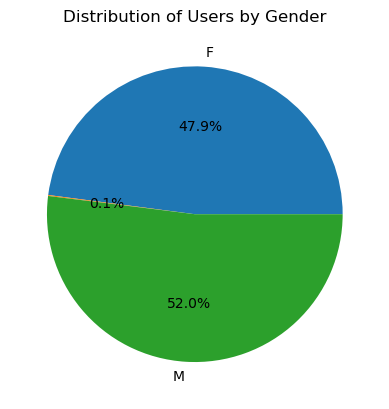

In [19]:
import matplotlib.pyplot as plt

gender_data = gender_count.collect()
labels = [row['gender'] for row in gender_data] # or df.topandas because matplotlib understands pandas and not spark dataframe
sizes = [row['count'] for row in gender_data]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Users by Gender')
plt.show()


### 12. Quel est l'artiste le plus écouté dans le dataset et combien de fois ses chansons ont-elles été jouées ?
Group by artist and count the occurrences:

In [20]:
top_artist = df.filter(col("page") == "NextSong").groupBy("artist").count().orderBy(desc("count")) # by adding filter by nextpage we focus on the songs most heard during suggestion
top_artist.show()


+--------------------+-----+
|              artist|count|
+--------------------+-----+
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|          Lily Allen|   28|
|Barry Tuckwell/Ac...|   28|
|               Train|   28|
|           Daft Punk|   27|
|          Nickelback|   27|
|           Metallica|   27|
|          Kanye West|   26|
|          John Mayer|   24|
+--------------------+-----+
only showing top 20 rows



### 13. Combien de chansons différentes ont été jouées dans l'ensemble des logs ?
How many unique songs have been played across all the logs?

In [25]:
from pyspark.sql.functions import countDistinct

# Count distinct songs
unique_songs_count = df.select(countDistinct("song")).collect()[0][0]
print(f"Number of unique songs played: {unique_songs_count}")
unique_songs_count = df.select(countDistinct("song")).show()

Number of unique songs played: 6125
+--------------------+
|count(DISTINCT song)|
+--------------------+
|                6125|
+--------------------+



## 14. Visualiser le nombre de chansons jouées par heure,  À quelle heure de la journée les utilisateurs écoutent-ils le plus de chansons ?
Visualize the number of songs played per hour: At what time of the day do users listen to the most songs?( to find number of songs being place at each hour in the day)

In [32]:
filter_df = df.filter(col("page") == "NextSong").count()

AttributeError: 'int' object has no attribute 'collect'

In [28]:
from pyspark.sql.functions import hour, col

# Extract hour from timestamp and count the songs played per hour(Time stamp gives you all the time a user spends all the time on the music app if we
# filter it by "nextpage" we can focus on the time spent for listning songs"


songs_per_hour = filter_df.withColumn("hour", hour((col("ts")/1000).cast("timestamp"))) \
                   .groupBy("hour") \
                   .count() \
                   .orderBy("hour")

songs_per_hour.show()

# Visualization with matplotlib
import matplotlib.pyplot as plt

pandas_df = songs_per_hour.toPandas()
plt.bar(pandas_df['hour'], pandas_df['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Number of songs played')
plt.title('Number of songs played per hour')
plt.show()


AttributeError: 'NoneType' object has no attribute 'withColumn'

### 15. Trouver les utilisateurs qui ont fait des upgrade et downgrade de leur abonnement?

(we can identify users who have either upgraded or downgraded their subscription by checking for changes in the level column)


In [31]:
df_up_down = df.filter(col("page").isin("Submit Downgrade", "Submit Upgrade")) \
               .select("userId", "level", "ts") \
               .orderBy("userId", "ts")

df_up_down.show()

# Identify users who have changed their level (both free and paid levels present)
users_with_changes = df_up_down.groupBy("userId").agg(countDistinct("level").alias("distinct_levels")) \
                               .filter(col("distinct_levels") >= 1) \
                               .select("userId")

users_with_changes.show()



+------+-----+-------------+
|userId|level|           ts|
+------+-----+-------------+
|  1079| free|1513749216284|
|  1138| paid|1513768454284|
|  1232| free|1513739104284|
|  1374| free|1513793239284|
|  1869| free|1513781766284|
|  2081| free|1513783320284|
|  2359| free|1513825672284|
|  2652| free|1513788509284|
|  2713| free|1513814900284|
|   512| free|1513730197284|
|   540| free|1513753826284|
+------+-----+-------------+

+------+
|userId|
+------+
|   512|
|  1079|
|  1232|
|  2359|
|  1138|
|  2713|
|   540|
|  1869|
|  1374|
|  2652|
|  2081|
+------+




16. Créer une vue temporaire répondre avec des requêtes SQL aux questions suivantes:

 a- Afficher les 3 premiers logs de l'utilisateur d'id 1046
 
 b- Trouver les pages que les utilisateurs ayant empty userID ont visité
 
 c- Combien de chansons ont été jouées par l'artiste le plus joué 
17. Proposer un axe d'analyse de votre choix ?


In [35]:
# Creating temporary view
df.createOrReplaceTempView("logs")


In [38]:
# Example 1: Display the first 3 logs for the user with userId 1046
spark.sql("""
    SELECT artist, firstName, location, registration, userAgent  FROM logs 
    WHERE userId = '1046' 
    ORDER BY ts 
    LIMIT 3
""").show()


+-------------+---------+--------------------+-------------+--------------------+
|       artist|firstName|            location| registration|           userAgent|
+-------------+---------+--------------------+-------------+--------------------+
|Showaddywaddy|  Kenneth|Charlotte-Concord...|1509380319284|"Mozilla/5.0 (Win...|
|Darius Rucker|  Kenneth|Charlotte-Concord...|1509380319284|"Mozilla/5.0 (Win...|
| Public Enemy|  Kenneth|Charlotte-Concord...|1509380319284|"Mozilla/5.0 (Win...|
+-------------+---------+--------------------+-------------+--------------------+



In [39]:
# Example 2: Find the pages visited by users with an empty userId
spark.sql("""
    SELECT DISTINCT page 
    FROM logs 
    WHERE userId = ''
""").show()


+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



In [40]:
# Example 3: How many songs were played by the most played artist?
spark.sql("""
    WITH artist_counts AS (
        SELECT artist, COUNT(*) AS song_count
        FROM logs
        WHERE artist IS NOT NULL
        GROUP BY artist
        ORDER BY song_count DESC
        LIMIT 1
    )
    SELECT song_count FROM artist_counts
""").show()

+----------+
|song_count|
+----------+
|        83|
+----------+



### 17. Proposer un axe d'analyse de votre choix ?

We can analyse the songs most played during the night time between (00:00 am until 3:00 am)

Steps:
Extract the hour from the timestamp.
Filter the logs to keep only those within the specified time range (12:00 AM to 3:00 AM).
Group by the song title and count the occurrences to find the most played songs.
Visualize the results using a bar chart.


In [41]:
spark.sql("""
    SELECT *  FROM logs 
    ORDER BY ts 
    LIMIT 3
""").show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shreveport-Bossie...|   PUT

In [54]:
# Extract the hour from the timestamp
df_with_hour = df.withColumn("hour", hour((col("ts")/1000).cast("timestamp")))
df_with_hour.select("hour","song").show()

+----+--------------------+
|hour|                song|
+----+--------------------+
|  22|Christmas Tears W...|
|  22|       Cheryl Tweedy|
|  22|Good Girls Go Bad...|
|  22| Don't See The Point|
|  22|                NULL|
|  22|                NULL|
|  22|        Smoke Buddah|
|  22|           On My Own|
|  22|                NULL|
|  22|                NULL|
|  22|Heart Of The City...|
|  22|    Bring Me To Life|
|  22|               Laura|
|  22|    Here Without You|
|  22|This Old House w/...|
|  22|Follow Me (Club Mix)|
|  22|                NULL|
|  22|                Undo|
|  22|Sheebeg And Sheemore|
|  22|Far Away (Album V...|
+----+--------------------+
only showing top 20 rows



In [55]:
# Filter for logs between 12:00 AM and 3:00 AM
night_time_df = df_with_hour.filter((col("hour") >= 0) & (col("hour") < 3))
night_time_df.select("hour","song").show()

+----+--------------------+
|hour|                song|
+----+--------------------+
|   0|             Mumbles|
|   0|Television Rules ...|
|   0|                Stay|
|   0|  Friend Of A Friend|
|   0|           Potential|
|   0|  Soul Of A Vagabond|
|   0|             Fix You|
|   0|  Lively Up Yourself|
|   0|                NULL|
|   0|      Garden Of Eden|
|   0|                NULL|
|   0|Praise You In Thi...|
|   0|Moron Brothers (l...|
|   0|                NULL|
|   0|             Fix You|
|   0|When This World F...|
|   0|Left With Alibis ...|
|   0|      Stupid In Love|
|   0|I Need You (Album...|
|   0|Moving Forward (f...|
+----+--------------------+
only showing top 20 rows



In [49]:
# Group by song and count the occurrences
songs_count = night_time_df.groupBy("song").count().orderBy(col("count").desc())

# Show the top 10 most played songs during the night time
songs_count.show(10, truncate=False)


+----------------+-----+
|song            |count|
+----------------+-----+
|NULL            |238  |
|Undo            |10   |
|You're The One  |8    |
|Revelry         |5    |
|Use Somebody    |5    |
|Invalid         |4    |
|Ain't Misbehavin|4    |
|Fuck Kitty      |4    |
|Stronger        |3    |
|Love Story      |3    |
+----------------+-----+
only showing top 10 rows



In [56]:
# Filter out rows where the song column is NULL
filtered_night_time_df = night_time_df.filter(col("song").isNotNull())


In [57]:
# Group by song and count the occurrences after filtering out NULLs
songs_count = filtered_night_time_df.groupBy("song").count().orderBy(col("count").desc())

# Show the top 10 most played songs during the night time
songs_count.show(10, truncate=False)


+----------------+-----+
|song            |count|
+----------------+-----+
|Undo            |10   |
|You're The One  |8    |
|Use Somebody    |5    |
|Revelry         |5    |
|Ain't Misbehavin|4    |
|Invalid         |4    |
|Fuck Kitty      |4    |
|Stronger        |3    |
|Love Story      |3    |
|Hello           |3    |
+----------------+-----+
only showing top 10 rows



/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


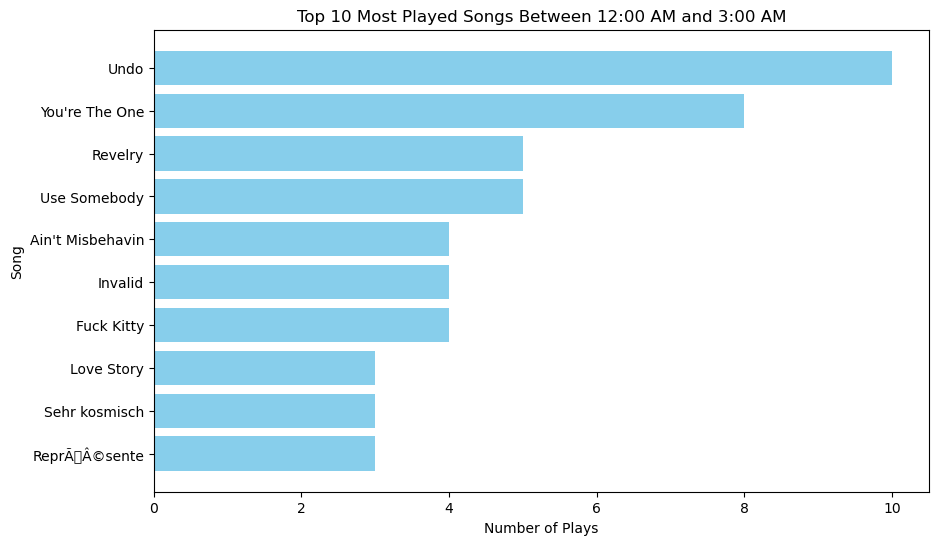

In [58]:
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas for visualization
songs_pandas_df = songs_count.limit(10).toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.barh(songs_pandas_df['song'], songs_pandas_df['count'], color='skyblue')
plt.xlabel('Number of Plays')
plt.ylabel('Song')
plt.title('Top 10 Most Played Songs Between 12:00 AM and 3:00 AM')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most played song at the top
plt.show()
